# Inputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from _Old.classes import System

# Material properties
wave_speed = 10.0  # Wave propagation speed (m/s)

# Mesh inputs (domain boundaries and element counts)
domain_x = [-1.0, 1.0]  # Domain boundaries along the X-axis
domain_y = [-1.0, 1.0]  # Domain boundaries along the Y-axis
num_elements_x = 120    # Number of elements along the X-axis
num_elements_y = 120    # Number of elements along the Y-axis

# Time-stepping parameters
total_time = 0.5       # Total simulation time (s)
time_steps = 1000       # Number of time steps



# Basic classes and function

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import pickle
from scipy.fft import fft2
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Gamma function for spatially varying density
def gamma_function(x, y):
    return 1

class Node:
    def __init__(self, x, y, u=0):
        self.x = x
        self.y = y
        self.u = u
        self.shape_xi = None
        self.shape_eta = None
    
    def info(self):
        return f"Node at ({self.x}, {self.y})"


class Element:
    def __init__(self, node1, node2, node3, node4, wavespeed):
        self.nodes = [node1, node2, node3, node4]
        self.c = wavespeed
        self.stiff = np.zeros((4, 4))
        self.mass = np.zeros((4, 4))
        self.set_isoparametric_coordinates()
        self.stiff, self.mass = self.calculate_matrices()

    def set_isoparametric_coordinates(self):
        self.nodes[0].shape_xi, self.nodes[0].shape_eta = -1, -1  # Bottom-left
        self.nodes[1].shape_xi, self.nodes[1].shape_eta = 1, -1   # Bottom-right
        self.nodes[2].shape_xi, self.nodes[2].shape_eta = 1, 1    # Top-right
        self.nodes[3].shape_xi, self.nodes[3].shape_eta = -1, 1   # Top-left

    def shape_function_derivatives(self, xi, eta):
        dN_dxi = [-(1 - eta) / 4, (1 - eta) / 4, (1 + eta) / 4, -(1 + eta) / 4]
        dN_deta = [-(1 - xi) / 4, -(1 + xi) / 4, (1 + xi) / 4, (1 - xi) / 4]
        return dN_dxi, dN_deta

    def jacobian(self, dN_dxi, dN_deta):
        J = np.zeros((2, 2))
        for i, node in enumerate(self.nodes):
            J[0, 0] += dN_dxi[i] * node.x
            J[0, 1] += dN_dxi[i] * node.y
            J[1, 0] += dN_deta[i] * node.x
            J[1, 1] += dN_deta[i] * node.y
        return J, np.linalg.det(J), np.linalg.inv(J)

    def calculate_B_matrix(self, invJ, dN_dxi, dN_deta):
        B = np.zeros((2, 4))
        for i in range(4):
            dN_dx = invJ[0, 0] * dN_dxi[i] + invJ[0, 1] * dN_deta[i]
            dN_dy = invJ[1, 0] * dN_dxi[i] + invJ[1, 1] * dN_deta[i]
            B[0, i] = dN_dx
            B[1, i] = dN_dy
        return B

    def calculate_matrices(self):
        K = np.zeros((4, 4))
        M = np.zeros((4, 4))
        gauss_points = [-1 / np.sqrt(3), 1 / np.sqrt(3)]
        weights = [1, 1]

        for xi in gauss_points:
            for eta in gauss_points:
                N = [
                    0.25 * (1 - xi) * (1 - eta),
                    0.25 * (1 + xi) * (1 - eta),
                    0.25 * (1 + xi) * (1 + eta),
                    0.25 * (1 - xi) * (1 + eta)
                ]
                
                dN_dxi, dN_deta = self.shape_function_derivatives(xi, eta)
                J, detJ, invJ = self.jacobian(dN_dxi, dN_deta)
                B = self.calculate_B_matrix(invJ, dN_dxi, dN_deta)
                
                x = sum(node.x * N[i] for i, node in enumerate(self.nodes))
                y = sum(node.y * N[i] for i, node in enumerate(self.nodes))
                gamma = gamma_function(x, y)
                
                for i in range(4):
                    for j in range(4):
                        K[i, j] += gamma * self.c**2 * (B[:, i] @ B[:, j]) * detJ * weights[0] * weights[1]
                        M[i, j] += gamma * N[i] * N[j] * detJ * weights[0] * weights[1]

        return K, M

def create_mesh(domain_x, domain_y, num_elements_x, num_elements_y, wavespeed):
    x_positions = np.linspace(domain_x[0], domain_x[1], num_elements_x + 1)
    y_positions = np.linspace(domain_y[0], domain_y[1], num_elements_y + 1)
    nodes = [Node(x, y) for y in y_positions for x in x_positions]

    elements = []
    for j in range(num_elements_y):
        for i in range(num_elements_x):
            node1 = nodes[j * (num_elements_x + 1) + i]
            node2 = nodes[j * (num_elements_x + 1) + (i + 1)]
            node3 = nodes[(j + 1) * (num_elements_x + 1) + (i + 1)]
            node4 = nodes[(j + 1) * (num_elements_x + 1) + i]
            
            elements.append(Element(node1, node2, node3, node4, wavespeed))
    
    # Indicate Mesh creating is done
    print("\nMesh is created.")
    print(f"Total number of nodes is {len(nodes)}")
    print(f"Total number of elements is {len(elements)}\n")

    return nodes, elements

class System:
    def __init__(self, domain_x=None, domain_y=None, num_elements_x=None, num_elements_y=None, wavespeed=None, filename=None):

        # Initialize the class with the save file.
        if filename:  # If a filename is provided, load the system from file
            self.load(filename)
        
        #Initialize the the class default
        else:
            self.domain_x = domain_x
            self.domain_y = domain_y
            self.num_elements_x = num_elements_x
            self.num_elements_y = num_elements_y
            self.nodes, self.elements = create_mesh(domain_x, domain_y, num_elements_x, num_elements_y, wavespeed)
            self.num_nodes = len(self.nodes)
            self.global_stiffness = np.zeros((self.num_nodes, self.num_nodes))
            self.global_mass = np.zeros((self.num_nodes, self.num_nodes))
            self.u_solved = None

            self.left_boundary, self.right_boundary, self.top_boundary, self.bottom_boundary = self.identify_boundary_nodes()

            self.assemble_global_matrices()

    def identify_boundary_nodes(self):
        left_boundary = []
        right_boundary = []
        top_boundary = []
        bottom_boundary = []
        
        for node in self.nodes:
            if node.x == self.domain_x[0]:      
                left_boundary.append(node)
            elif node.x == self.domain_x[1]:    
                right_boundary.append(node)
            if node.y == self.domain_y[1]:      
                top_boundary.append(node)
            elif node.y == self.domain_y[0]:    
                bottom_boundary.append(node)
                
        return left_boundary, right_boundary, top_boundary, bottom_boundary
    
    def get_middle_node(self):
        # Calculate the midpoint coordinates of the domain
        x_mid = (self.domain_x[0] + self.domain_x[1]) / 2
        y_mid = (self.domain_y[0] + self.domain_y[1]) / 2

        # Find the node closest to the midpoint
        middle_node = min(
            self.nodes, 
            key=lambda node: (node.x - x_mid) ** 2 + (node.y - y_mid) ** 2
        )

        return middle_node
    
    def get_info(self, detailed = False):
        """
        Return the sizes of the mass, stiffness, and force matrices.
        """

        mass_size = self.global_mass.shape
        stiffness_size = self.global_stiffness.shape
        force_size = self.force_time_series.shape

        print(f"\nMass matrix size: {mass_size}")
        print(f"Stiffness matrix size: {stiffness_size}")
        print(f"Force vector size: {force_size}")

        if self.u_solved is not None:
            u_solved_size = self.u_solved.shape
            print(f"Displacement (u_solved) size: {u_solved_size}\n")
        
        if detailed:
            # Calculate the index of the middle node
            middle_node_index = len(self.nodes) // 2
            print(f"Middle node index: {middle_node_index}")
            print(f"Middle node coordinates: ({self.nodes[middle_node_index].x}, {self.nodes[middle_node_index].y})")
            # We can add e.g. self bounday nodes or another infos
    
    def assemble_global_matrices(self):
        for element in self.elements:
            local_stiffness = element.stiff
            local_mass = element.mass
            node_indices = [self.nodes.index(node) for node in element.nodes]

            for i in range(4):
                for j in range(4):
                    global_i = node_indices[i]
                    global_j = node_indices[j]
                    self.global_stiffness[global_i, global_j] += local_stiffness[i, j]
                    self.global_mass[global_i, global_j] += local_mass[i, j]

    def apply_boundary_conditions(self):
        for i in range(self.num_nodes):
            if (self.nodes[i].x == self.domain_x[0] or self.nodes[i].x == self.domain_x[1] or 
                self.nodes[i].y == self.domain_y[0] or self.nodes[i].y == self.domain_y[1]):
                
                self.global_stiffness[i, :] = 0
                self.global_stiffness[i, i] = 1
                self.force_vector[i] = 0
                
    def set_initial_conditions(self):
        x0 = (self.domain_x[0] + self.domain_x[1]) / 2
        y0 = (self.domain_y[0] + self.domain_y[1]) / 2
        sigma = 0.25  

        u_0 = np.zeros(self.num_nodes) 
        for idx, node in enumerate(self.nodes):
            node.u = 2 * np.exp(-((node.x - x0) ** 2 + (node.y - y0) ** 2) / (2 * sigma ** 2))
            u_0[idx] = node.u

        self.force_vector = -self.global_stiffness@u_0  

        
    def generateSineBurst(self, frequency, cycles = 3, amplitude = 1):
        omega = frequency * 2 * np.pi            
        return (
            lambda t: amplitude
            * np.sin(omega * t)
            )  # normalization over the applied area
    
    def apply_sine_burst_force(self, total_time, time_steps, frequency=10, cycles=3, amplitude=1e3):
        # Create the sine burst function
        sine_burst = self.generateSineBurst(frequency, cycles, amplitude)
        
        # Get middle node and its index in force vector
        middle_node = self.get_middle_node()
        middle_node_index = self.nodes.index(middle_node)
        
        # Initialize time-dependent force vector (size: num_nodes x time_steps)
        dt = total_time / time_steps
        force_time_series = np.zeros((self.num_nodes, time_steps))  # Matrix with size (num_nodes, time_steps)
        
        # Apply the sine burst force at the middle node for each time step
        for t_index in range(time_steps):
            t = t_index * dt
            force_time_series[middle_node_index, t_index] = sine_burst(t)  # Update for each time step

            # Indicate the process
            if t_index % (time_steps // 5) == 0:  # Progress every 20% of time steps
                print(f"Force vector is being calculated: {100 * t_index / time_steps:.2f}%")
        
        print(f"Force vector is calculated SUCCESSFULLY!   {force_time_series.shape}")

        return force_time_series
    
    def solve_time_domain(self, total_time, time_steps, save_filename = None):
        dt = total_time / time_steps

        # Displacement matrix initialized with zeroes for each time step
        u = np.zeros((self.num_nodes, time_steps))

        # Time-dependent force vector initialized
        self.force_time_series = self.apply_sine_burst_force(total_time, time_steps)

        # Indicate that solving is starting
        print("\nSolving is STARTING...")

        # Print the matrix sizes at the start
        self.get_info()
        
        # Set up finite difference coefficients
        mass_inv = np.linalg.inv(self.global_mass)
        stiffness_term = mass_inv @ self.global_stiffness  # Pre-computed for efficiency
        
        # Indicate coefficients are calculated
        print("\nSolving coefficients are calculated")

        # Iterate over time steps, updating displacements using finite difference
        for i in range(2, time_steps):
            
            # Display current row / total row to follow solving process
            if i % 10 == 0:
                print(f"Solving time step: {i} / {time_steps}")

            # Finite difference update for each node
            u[:, i] = (
                2 * u[:, i - 1] 
                - u[:, i - 2] 
                + (dt**2) * (mass_inv @ self.force_time_series[:, i-1] - stiffness_term @ u[:, i-1])
            )

        print("\nSYSTEM IS SOLVED SUCCESSFULLY!")

        self.u_solved = u

        # If a filename is provided, save the system
        if save_filename:
            self.save(save_filename)

        return u
    

    def solve_frequency_domain(self, total_time,time_steps):

        # Freqeuncy range - consistent to time domain
        freq = np.fft.rfftfreq(time_steps, total_time / time_steps)

        # Compute the FFT along the time axis
        u_sol_time2freq = np.fft.rfft2(self.u_solved, axes=(1,))

        print("FFT2 result shape:", u_sol_time2freq.shape)

        # Initialize the frequency domain displacement array and introduce imaginary unit
        u_f = np.zeros((len(freq), self.num_nodes), dtype=complex)
        u_f = u_f + (1j*0)

        # Pre-convert global stiffness and mass matrices to sparse if large
        global_stiffness_sparse = csr_matrix(self.global_stiffness)
        global_mass_sparse = csr_matrix(self.global_mass)

        # Transform force vector into frequency domain for appropiate solution size
        force_time2freq = np.fft.rfft2(self.force_time_series, axes=(1,))

        # Iterate through frequencies
        for i in range(len(freq)):
            omega = 2 * np.pi * freq[i]

            # Construct the impedance matrix and introduce imaginary unit
            impedance_matrix = global_stiffness_sparse - omega**2 * global_mass_sparse
            impedance_matrix = impedance_matrix + (1j*0)

            # Extract force vector for the current frequency
            force_freq = force_time2freq[:, i]

            # Solve for displacement at this frequency
            try:
                u_f[i, :] = spsolve(impedance_matrix, force_freq)
            except Exception as e:
                print(f"Error at frequency {freq}: {e}")
                u_f[i, :] = np.nan 

        # Store the result in the object and return
        self.u_solved_freq = u_f
        print("Frequency domain result shape:", self.u_solved_freq.shape)

        # Check whether values are same
        is_close = np.allclose(u_sol_time2freq, self.u_solved_freq.T, rtol=1e-3, atol=1e-5)
        print(f"Are the solutions close? {is_close}")

        # Calculate absolute differences
        differences = np.abs(u_sol_time2freq - self.u_solved_freq.T)

        # Plot the differences
        plt.figure(figsize=(10, 6))
        plt.imshow(differences, aspect='auto', cmap='viridis',vmax=10,vmin=0)
        plt.colorbar(label='Absolute Difference')
        plt.xlabel('Node Index')
        plt.ylabel('Frequency Index')
        plt.title('Absolute Difference Between Solutions')
        plt.show()

        return u_f


    # Function for saving the system variables after solving
    def save(self, filename):
        """
        Save all relevant variables of the system to a file.
        """
        data = {
            'nodes': self.nodes,
            'elements': self.elements,
            'num_elements_x': self.num_elements_x,
            'num_elements_y': self.num_elements_y,
            'global_stiffness': self.global_stiffness,
            'global_mass': self.global_mass,
            'left_boundary': self.left_boundary,
            'right_boundary': self.right_boundary,
            'top_boundary': self.top_boundary,
            'bottom_boundary': self.bottom_boundary,
            'domain_x': self.domain_x,
            'domain_y': self.domain_y,
            'num_nodes': self.num_nodes,
            'force_time_series': self.force_time_series,
            'u_solved': self.u_solved
        }

        # Save using numpy for matrices and pickling for the rest
        with open(filename, 'wb') as file:
            pickle.dump(data, file)

        print(f"\nSystem saved successfully to {filename}.")

    # Loading the saved data file
    def load(self, filename):
        """
        Load the system from the saved file.
        """
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        
        self.nodes = data['nodes']
        self.elements = data['elements']
        self.num_elements_x = data['num_elements_x']
        self.num_elements_y = data['num_elements_y']
        self.global_stiffness = data['global_stiffness']
        self.global_mass = data['global_mass']
        self.left_boundary = data['left_boundary']
        self.right_boundary = data['right_boundary']
        self.top_boundary = data['top_boundary']
        self.bottom_boundary = data['bottom_boundary']
        self.domain_x = data['domain_x']
        self.domain_y = data['domain_y']
        self.num_nodes = data['num_nodes']
        self.force_time_series = data['force_time_series']
        self.u_solved = data['u_solved']

        print(f"\nSystem loaded successfully from {filename}.")
    

    # Function to animate wave propagation over time
    def animate_wave_propagation_time(self, total_time, time_steps):
        """ Set up the plot and animation for real-time updates """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Calculate the time step interval
        dt = total_time / time_steps

        # Set some values below threshold 0 
        u_solved_max = self.u_solved.max()
        u_solved_min = self.u_solved.min()
        threshold = 0.1 * self.u_solved.max()
        
        u_solved_masked = np.where((self.u_solved > threshold) | (self.u_solved < -threshold),
                                   self.u_solved, 0)
    
        # Shaping u for animation for first time step
        reshaped_u = u_solved_masked[:, 0].reshape(self.num_elements_y + 1, self.num_elements_x + 1)
        
        # Creating starting image
        self.im = ax.imshow(
            reshaped_u, 
            cmap='viridis', 
            animated=True, 
            interpolation='bilinear', 
            extent=[self.domain_x[0], self.domain_x[1], self.domain_y[0], self.domain_y[1]],
            vmin=u_solved_min,
            vmax=u_solved_max
        )

        # Titles and labels
        ax.set_title("Wave Propagation Over Time")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
    
        # Setting axes
        ax.set_xticks(np.linspace(self.domain_x[0], self.domain_x[1], 5))
        ax.set_yticks(np.linspace(self.domain_y[0], self.domain_y[1], 5))
    
        """ Update function w.r.t frames """
        def update(frame):
            # Update function for the animation 
            # Shaping u for each frame
            reshaped_u = u_solved_masked[:, frame].reshape(self.num_elements_y + 1, self.num_elements_x + 1)
            
            # Update image
            self.im.set_array(reshaped_u)
            self.im.set_clim(vmin=reshaped_u.min(), vmax=reshaped_u.max())
            
            # Display time at the top
            ax.set_title(f"Wave Propagation at t = {frame * dt:.2f} s")
            
            return [self.im]
    
        # FuncAnimation
        ani = FuncAnimation(fig, update, frames=time_steps, interval=100, blit=False)
    
        # Show animation
        plt.show()
        

# Frequency domain solution


System loaded successfully from data.
FFT2 result shape: (14641, 501)
Frequency domain result shape: (501, 14641)
Are the solutions close? False


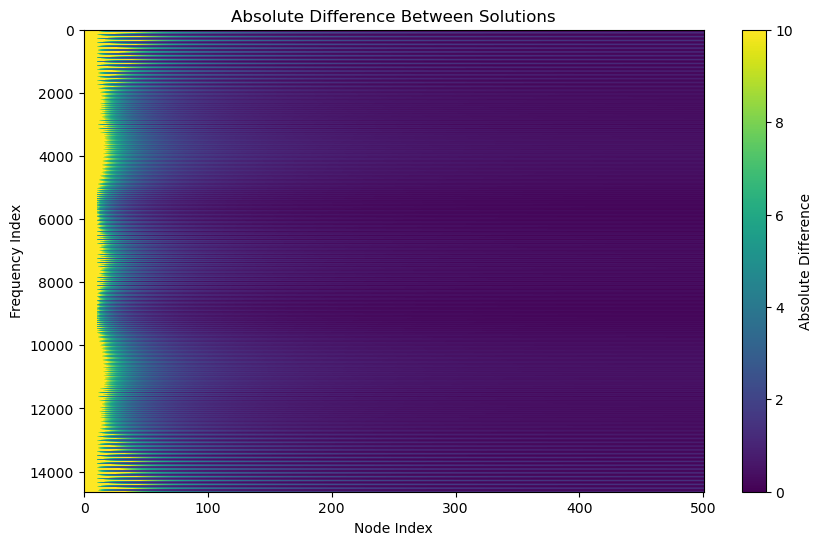

(501, 14641)

Mass matrix size: (14641, 14641)
Stiffness matrix size: (14641, 14641)
Force vector size: (14641, 1000)
Displacement (u_solved) size: (14641, 1000)

Middle node index: 7320
Middle node coordinates: (0.0, 0.0)


In [46]:
#Initialize the system
system = System(filename="data")

u_freq = system.solve_frequency_domain(total_time, time_steps)
u_freq2time = np.fft.irfft2(u_freq)
print(u_freq.shape)
system.get_info(detailed=True)

In [ ]:
# Initialize the system
system = System(domain_x, domain_y, num_elements_x, num_elements_y, wave_speed)


# Solve the system in the time domain
u_time = system.solve_time_domain(total_time, time_steps)

In [36]:
u_freq2time = np.fft.irfft2(u_freq.T)

In [37]:
u_sol_time2freq = np.fft.rfft(system.u_solved)

/Users/lalemauzi/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


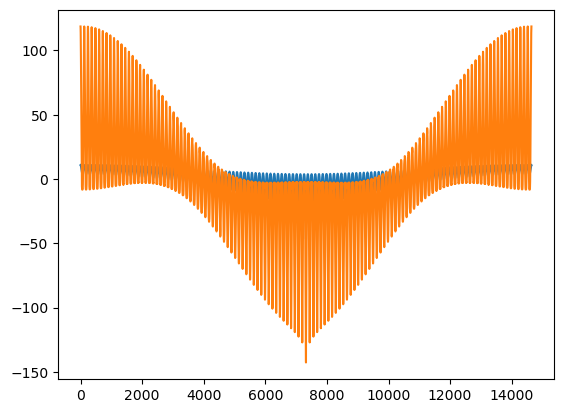

In [38]:
plt.plot(u_freq[2,:])
plt.plot(u_sol_time2freq[:,2])

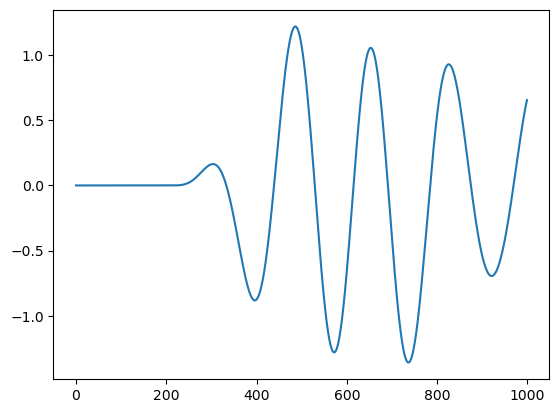

In [40]:
plt.plot(system.u_solved[515,:])


Mesh is created.
Total number of nodes is 14641
Total number of elements is 14400

Force vector is being calculated: 0.00%
Force vector is being calculated: 20.00%
Force vector is being calculated: 40.00%
Force vector is being calculated: 60.00%
Force vector is being calculated: 80.00%
Force vector is calculated SUCCESSFULLY!   (14641, 1000)

Solving is STARTING...

Mass matrix size: (14641, 14641)
Stiffness matrix size: (14641, 14641)
Force vector size: (14641, 1000)

Solving coefficients are calculated
Solving time step: 10 / 1000
Solving time step: 20 / 1000
Solving time step: 30 / 1000
Solving time step: 40 / 1000
Solving time step: 50 / 1000
Solving time step: 60 / 1000
Solving time step: 70 / 1000
Solving time step: 80 / 1000
Solving time step: 90 / 1000
Solving time step: 100 / 1000
Solving time step: 110 / 1000
Solving time step: 120 / 1000
Solving time step: 130 / 1000
Solving time step: 140 / 1000
Solving time step: 150 / 1000
Solving time step: 160 / 1000
Solving time step: